<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-END-Program/blob/main/09-%20HandsOn%203/openBookQA/openBookQA_dataset_Align_and_translate_RNN_Encoder_Decoder_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The openBookQA - RNN Seq2Seq Encoder Decoder solution with Translation by Jointly Learning to Align and Translate

The model implemented avoids compression at context vector by allowing the decoder to look at the entire source sentence (via its hidden states) at each decoding step. This is done by using Attention.

Attention works by first, calculating an attention vector, $a$, that is the length of the source sentence. The attention vector has the property that each element is between 0 and 1, and the entire vector sums to 1. We then calculate a weighted sum of our source sentence hidden states, $H$, to get a weighted source vector, $w$. 

$$w = \sum_{i}a_ih_i$$

We calculate a new weighted source vector every time-step when decoding, using it as input to our decoder RNN as well as the linear layer to make a prediction.

openBookQA

Dataset contains questions set for 1329 elementary level scientific facts. There are about 6000 questions focused on these facts.

Files

OpenBookQA-V1-Sep2018\Data\Main folder contains train, test and dev(valid) json files. These files contain question column. Question further contains stem question and 4 answer choices for them. The correct answer from the answer choice is given in answerKey.

File required - train.jsonl, test.jsonl and dev.jsonl

Learnings:

Learnings:

1. Encoder uses bidirectional GRU to encode the context vector. Bidirection GRUs create 2 context vector, one for each direction. Decoder block requires single context vector. This is created by concatenating the two context vectors together, passing them through a linear layer, g, and applying the tanh  activation function.

2. Attention vector is calculated from previous hidden state of the decoder,  st−1 , and all of the stacked forward and backward hidden states from the encoder. Attention vector calculates how well each encoder hidden state matches the previous decoder hidden state.

3. Decoder uses the weighted attention vector along with previous decoder hidden state to calculate decoder hidden state. Attention vector is also used along with decoder hidden state to predict the next word.

4. Test Loss observed is 4.388 with perplexity score of 80.476.

### Additional packages

In [ ]:
# Packages
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import data
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Load Dataset

In [ ]:
OPENBOOKQA_DATA_URL="https://s3-us-west-2.amazonaws.com/ai2-website/data/OpenBookQA-V1-Sep2018.zip"
!wget $OPENBOOKQA_DATA_URL
!unzip $(basename $OPENBOOKQA_DATA_URL)

--2021-01-04 14:22:30--  https://s3-us-west-2.amazonaws.com/ai2-website/data/OpenBookQA-V1-Sep2018.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.242.216
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.242.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1446098 (1.4M) [application/zip]
Saving to: ‘OpenBookQA-V1-Sep2018.zip’

OpenBookQA-V1-Sep20 100%[===================>]   1.38M  --.-KB/s    in 0.08s   

2021-01-04 14:22:30 (17.8 MB/s) - ‘OpenBookQA-V1-Sep2018.zip’ saved [1446098/1446098]

Archive:  OpenBookQA-V1-Sep2018.zip
   creating: OpenBookQA-V1-Sep2018/
   creating: OpenBookQA-V1-Sep2018/Data/
   creating: OpenBookQA-V1-Sep2018/Data/Additional/
  inflating: OpenBookQA-V1-Sep2018/Data/Additional/test_complete.jsonl  
  inflating: OpenBookQA-V1-Sep2018/Data/Additional/train_complete.jsonl  
  inflating: OpenBookQA-V1-Sep2018/Data/Additional/crowdsourced-facts.txt  
  inflating: OpenBookQA-V

Function to extract train, test and valid dataset from the json files. Complete steps in previous notebook.

In [ ]:
def answer_select(x, a, b, c, d):
    if x == 'A':
        return a
    elif x == 'B':
        return b
    elif x == 'C':
        return c
    elif x == 'D':
        return d

func = np.vectorize(answer_select)

def json_to_df(filename, func):
    df_openBookQA = pd.read_json(path_or_buf=filename, lines=True)
    df_openBookQA = df_openBookQA.join(pd.json_normalize(df_openBookQA.question))
    df_openBookQA = df_openBookQA.join(pd.DataFrame(df_openBookQA.choices.to_list(), columns=['A','B','C','D']))
    df_openBookQA["answer_dict"] = pd.DataFrame(func(df_openBookQA["answerKey"], df_openBookQA["A"], 
                                df_openBookQA["B"], df_openBookQA["C"], df_openBookQA["D"]))
    df_openBookQA = df_openBookQA.join(pd.json_normalize(df_openBookQA.answer_dict))
    return df_openBookQA[['stem', 'text']].rename(columns={'stem': 'question', 'text': 'answer1'})

Data frame for train

In [ ]:
df_train_qa = json_to_df('/content/OpenBookQA-V1-Sep2018/Data/Main/train.jsonl',func)
print(df_train_qa.shape)
df_train_qa.head()

(4957, 2)


,question,answer1
0,The sun is responsible for,"plants sprouting, blooming and wilting"
1,When standing miles away from Mount Rushmore,the mountains seem smaller than in photographs
2,When food is reduced in the stomach,nutrients are being deconstructed
3,Stars are,great balls of gas burning billions of miles away
4,You can make a telescope with a,mailing tube


Dataframe for test

In [ ]:
df_test_qa = json_to_df('/content/OpenBookQA-V1-Sep2018/Data/Main/test.jsonl',func)
print(df_test_qa.shape)
df_test_qa.head()

(500, 2)


,question,answer1
0,A person wants to start saving money so that t...,quit eating lunch out
1,There is most likely going to be fog around:,a marsh
2,Predators eat,bunnies
3,Oak tree seeds are planted and a sidewalk is p...,parts may break the concrete
4,An electric car runs on electricity via,electrical conductors


Dataframe for validation

In [ ]:
df_valid_qa = json_to_df('/content/OpenBookQA-V1-Sep2018/Data/Main/dev.jsonl',func)
print(df_valid_qa.shape)
df_valid_qa.head()

(500, 2)


,question,answer1
0,Frilled sharks and angler fish live far beneat...,Deep sea animals
1,"Gas can fill any container it is given, and li...",uses what it needs
2,"When birds migrate south for the winter, they ...",they are genetically called to
3,If a person walks in the opposite direction of...,south
4,An example of lots kinetic energy would be,An aircraft taking a trip


### Download and load spacy models

This is going to be used for tokenization.

In [ ]:
# Download and load spacy models for EN language. To be used for tokenization.
%%bash
python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
spacy_en = spacy.load('en')

In [ ]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
tokenize_en("Spacy model for EN is loaded up.")

['Spacy', 'model', 'for', 'EN', 'is', 'loaded', 'up', '.']

### Prepare FIELDS

Defines a datatype together with instructions for converting to Tensor. holds a Vocab object that defines the set of possible values
    for elements of the field and their corresponding numerical representations.

QUESTIONS - Field containing the questions for training.
ANSWERS - Field for prediction.

In [ ]:
QUESTIONS = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)
ANSWERS = Field(tokenize = tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

In [ ]:
print(type(QUESTIONS))
QUESTIONS.__dict__

<class 'torchtext.data.field.Field'>


{'batch_first': False,
 'dtype': torch.int64,
 'eos_token': '<eos>',
 'fix_length': None,
 'include_lengths': False,
 'init_token': '<sos>',
 'is_target': False,
 'lower': True,
 'pad_first': False,
 'pad_token': '<pad>',
 'postprocessing': None,
 'preprocessing': None,
 'sequential': True,
 'stop_words': None,
 'tokenize': <function __main__.tokenize_en>,
 'truncate_first': False,
 'unk_token': '<unk>',
 'use_vocab': True}

Create a list of (name, field) pairs as the fields argument. The fields we pass in must be in the same order as the columns

In [ ]:
fields = [('question', QUESTIONS), ('answer1', ANSWERS)]

Convert from pandas to list to torchtext.

In [ ]:
example_train = [data.Example.fromlist([df_train_qa.question[i],df_train_qa.answer1[i]], fields) for i in range(df_train_qa.shape[0])] 
example_valid = [data.Example.fromlist([df_valid_qa.question[i],df_valid_qa.answer1[i]], fields) for i in range(df_valid_qa.shape[0])] 
example_test = [data.Example.fromlist([df_test_qa.question[i],df_test_qa.answer1[i]], fields) for i in range(df_test_qa.shape[0])] 

In [ ]:
# Creating dataset
train_data = data.Dataset(example_train, fields)
valid_data = data.Dataset(example_valid, fields)
test_data = data.Dataset(example_test, fields)

In [ ]:
print(vars(train_data.examples[0]))

{'question': ['the', 'sun', 'is', 'responsible', 'for'], 'answer1': ['plants', 'sprouting', ',', 'blooming', 'and', 'wilting']}


In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 4957
Number of validation examples: 500
Number of testing examples: 500


### Build vocabulary for SRC and TRG

Vocabulary will associate each unique tokens with an index. Only tokens that appear atleast 2 times are considered. Other such words are replaced by < UNK >. Vocab object built on only training examples.

In [ ]:
QUESTIONS.build_vocab(train_data, min_freq = 2)
ANSWERS.build_vocab(train_data, min_freq = 2)

In [ ]:
print("Size of Source vocab: ",len(QUESTIONS.vocab))
print("Size of Target vocab: ",len(ANSWERS.vocab))

Size of Source vocab:  2903
Size of Target vocab:  1904


In [ ]:
vars(QUESTIONS)

{'batch_first': False,
 'dtype': torch.int64,
 'eos_token': '<eos>',
 'fix_length': None,
 'include_lengths': False,
 'init_token': '<sos>',
 'is_target': False,
 'lower': True,
 'pad_first': False,
 'pad_token': '<pad>',
 'postprocessing': None,
 'preprocessing': None,
 'sequential': True,
 'stop_words': None,
 'tokenize': <function __main__.tokenize_en>,
 'truncate_first': False,
 'unk_token': '<unk>',
 'use_vocab': True,
 'vocab': <torchtext.vocab.Vocab at 0x7f3fc8bed7b8>}

In [ ]:
# QUESTIONS.vocab dict has the following keys - freqs(provides word and its frequencies), itos(mapping of integer to string), 
# stoi(mapping of string to its integer) and vectors()
print(QUESTIONS.vocab.__dict__.keys())
QUESTIONS.vocab.__dict__

dict_keys(['freqs', 'itos', 'stoi', 'vectors'])


{'freqs': Counter({'the': 2392,
          'sun': 75,
          'is': 1765,
          'responsible': 10,
          'for': 393,
          'when': 382,
          'standing': 9,
          'miles': 14,
          'away': 37,
          'from': 323,
          'mount': 1,
          'rushmore': 1,
          'food': 113,
          'reduced': 3,
          'in': 1092,
          'stomach': 3,
          'stars': 10,
          'are': 426,
          'you': 292,
          'can': 495,
          'make': 110,
          'a': 3185,
          'telescope': 5,
          'with': 261,
          'poison': 4,
          'causes': 72,
          'harm': 14,
          'to': 1868,
          'which': 761,
          'of': 1640,
          'following': 108,
          '?': 1771,
          'an': 618,
          'inherited': 13,
          'characteristic': 16,
          'found': 52,
          'on': 388,
          'all': 90,
          'mammals': 7,
          'what': 1000,
          'does': 87,
          "n't": 13,
          'eli

### Create iterators for train, valid and test.

BucketIterator is used instead of Standard Iterator. BucketIterator defines an iterator that batches examples of similar lengths together.

Minimizes amount of padding needed while producing freshly shuffled batches for each new epoch.

batch.QUESTIONS - [ (128) , (128), .. 23 times]**bold text**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# TypeError: '<' not supported between instances of 'Example' and 'Example'
# This happens because the dataset iterator from torchtext tries to sort the dataset, which implies comparing two elements. 
# have to provide a sorting function to the constructor of the BucketIterator
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort=False,
    batch_size = BATCH_SIZE, 
    device = device)

In [ ]:
batch = next(iter(train_iterator))
print(batch)


[torchtext.data.batch.Batch of size 128]
	[.question]:[torch.cuda.LongTensor of size 36x128 (GPU 0)]
	[.answer1]:[torch.cuda.LongTensor of size 14x128 (GPU 0)]


In [ ]:
# Batch contains question and answer1. Can be accessed as batch.question (tensor) and batch.answer1 (tensor)
# batch.question groups the first element of all sequences in batch of 128, then groups second element of sequence in batch 128.
print(type(batch))
print(batch)
print('Data type of batch.question', type(batch.question))
print("Length of a source sequence", len(batch.question))
print("Length of source at first index. (2 is for <sos>)", len(batch.question[0]))
print("Length of source at last index. (6 - what , 8- does )", len(batch.question[-1]))
print("Values at source first index", batch.question[0])
print(batch.answer1[1])

<class 'torchtext.data.batch.Batch'>

[torchtext.data.batch.Batch of size 128]
	[.question]:[torch.cuda.LongTensor of size 36x128 (GPU 0)]
	[.answer1]:[torch.cuda.LongTensor of size 14x128 (GPU 0)]
Data type of batch.question <class 'torch.Tensor'>
Length of a source sequence 36
Length of source at first index. (2 is for <sos>) 128
Length of source at last index. (6 - what , 8- does ) 128
Values at source first index tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor([   0,    0, 1722,   90,   44,   73, 1636,    5, 1542,    4,    0,  770,
           0,   57,  111, 1628,    9,    0,    5,

### Building the Seq2Seq Model

#### Encoder

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU, however we now use a *bidirectional RNN*. With a bidirectional RNN, we have two RNNs in each layer. A *forward RNN* going over the embedded sentence from left to right (shown below in green), and a *backward RNN* going over the embedded sentence from right to left (teal). All we need to do in code is set `bidirectional = True` and then pass the embedded sentence to the RNN as before. 

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq8.png?raw=1)

We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

As before, we only pass an input (`embedded`) to the RNN, which tells PyTorch to initialize both the forward and backward initial hidden states ($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively) to a tensor of all zeros. We'll also get two context vectors, one from the forward RNN after it has seen the final word in the sentence, $z^\rightarrow=h_T^\rightarrow$, and one from the backward RNN after it has seen the first word in the sentence, $z^\leftarrow=h_T^\leftarrow$.

The RNN returns `outputs` and `hidden`. 

`outputs` is of size **[src len, batch size, hid dim * num directions]** where the first `hid_dim` elements in the third axis are the hidden states from the top layer forward RNN, and the last `hid_dim` elements are hidden states from the top layer backward RNN. We can think of the third axis as being the forward and backward hidden states concatenated together other, i.e. $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$ and we can denote all encoder hidden states (forward and backwards concatenated together) as $H=\{ h_1, h_2, ..., h_T\}$.

`hidden` is of size **[n layers * num directions, batch size, hid dim]**, where **[-2, :, :]** gives the top layer forward RNN hidden state after the final time-step (i.e. after it has seen the last word in the sentence) and **[-1, :, :]** gives the top layer backward RNN hidden state after the final time-step (i.e. after it has seen the first word in the sentence).

As the decoder is not bidirectional, it only needs a single context vector, $z$, to use as its initial hidden state, $s_0$, and we currently have two, a forward and a backward one ($z^\rightarrow=h_T^\rightarrow$ and $z^\leftarrow=h_T^\leftarrow$, respectively). We solve this by concatenating the two context vectors together, passing them through a linear layer, $g$, and applying the $\tanh$ activation function. 

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

**Note**: this is actually a deviation from the paper. Instead, they feed only the first backward RNN hidden state through a linear layer to get the context vector/decoder initial hidden state. This doesn't seem to make sense to me, so we have changed it.

As we want our model to look back over the whole of the source sentence we return `outputs`, the stacked forward and backward hidden states for every token in the source sentence. We also return `hidden`, which acts as our initial hidden state in the decoder.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

Next up is the attention layer. This will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far, $s_{t-1}$, and all of what we have encoded, $H$, to produce a vector, $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$. 

First, we calculate the *energy* between the previous decoder hidden state and the encoder hidden states. As our encoder hidden states are a sequence of $T$ tensors, and our previous decoder hidden state is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. We then calculate the energy, $E_t$, between them by concatenating them together and passing them through a linear layer (`attn`) and a $\tanh$ activation function. 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[dec hid dim, src len]** tensor for each example in the batch. We want this to be **[src len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, dec hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$

We can think of $v$ as the weights for a weighted sum of the energy across all encoder hidden states. These weights tell us how much we should attend to each token in the source sequence. The parameters of $v$ are initialized randomly, but learned with the rest of the model via backpropagation. Note how $v$ is not dependent on time, and the same $v$ is used for each time-step of the decoding. We implement $v$ as a linear layer without a bias.

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!

Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/teal blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq9.png?raw=1)

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

### Decoder

Next up is the decoder. 

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The embedded input word, $d(y_t)$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $d(y_t)$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

We then pass $d(y_t)$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq10.png?raw=1)

The green/teal blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

### Seq2Seq

This is the first model where we don't have to have the encoder RNN and decoder RNN have the same hidden dimensions, however the encoder has to be bidirectional. This requirement can be removed by changing all occurences of `enc_dim * 2` to `enc_dim * 2 if encoder_is_bidirectional else enc_dim`. 

This seq2seq encapsulator is similar to the last two. The only difference is that the `encoder` returns both the final hidden state (which is the final hidden state from both the forward and backward encoder RNNs passed through a linear layer) to be used as the initial hidden state for the decoder, as well as every hidden state (which are the forward and backward hidden states stacked on top of each other). We also need to ensure that `hidden` and `encoder_outputs` are passed to the decoder. 

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

## Training the Seq2Seq Model

The rest of this session is very similar to the previous one.

We initialise our parameters, encoder, decoder and seq2seq model (placing it on the GPU if we have one). 

In [ ]:
INPUT_DIM = len(QUESTIONS.vocab)
OUTPUT_DIM = len(ANSWERS.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(2903, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(1904, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=1904, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,077,744 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
TRG_PAD_IDX = ANSWERS.vocab.stoi[ANSWERS.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.question
        trg = batch.answer1
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.question
            trg = batch.answer1

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_loss_all = []
val_loss_all = []

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    train_loss_all.append(train_loss)
    val_loss_all.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 5s
	Train Loss: 5.580 | Train PPL: 265.147
	 Val. Loss: 4.547 |  Val. PPL:  94.314
Epoch: 02 | Time: 0m 5s
	Train Loss: 4.864 | Train PPL: 129.574
	 Val. Loss: 4.475 |  Val. PPL:  87.791
Epoch: 03 | Time: 0m 5s
	Train Loss: 4.729 | Train PPL: 113.235
	 Val. Loss: 4.476 |  Val. PPL:  87.879
Epoch: 04 | Time: 0m 5s
	Train Loss: 4.628 | Train PPL: 102.292
	 Val. Loss: 4.495 |  Val. PPL:  89.552
Epoch: 05 | Time: 0m 5s
	Train Loss: 4.532 | Train PPL:  92.918
	 Val. Loss: 4.453 |  Val. PPL:  85.875
Epoch: 06 | Time: 0m 5s
	Train Loss: 4.452 | Train PPL:  85.836
	 Val. Loss: 4.499 |  Val. PPL:  89.913
Epoch: 07 | Time: 0m 5s
	Train Loss: 4.353 | Train PPL:  77.718
	 Val. Loss: 4.531 |  Val. PPL:  92.896
Epoch: 08 | Time: 0m 5s
	Train Loss: 4.247 | Train PPL:  69.879
	 Val. Loss: 4.576 |  Val. PPL:  97.143
Epoch: 09 | Time: 0m 5s
	Train Loss: 4.148 | Train PPL:  63.290
	 Val. Loss: 4.633 |  Val. PPL: 102.806
Epoch: 10 | Time: 0m 5s
	Train Loss: 4.046 | Train PPL:  57.193


In [ ]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.388 | Test PPL:  80.476 |


Train, val loss curve

In [ ]:
import matplotlib.pyplot as plt
def train_test_metrics_graph(train_loss_all, val_loss_all):

    plt.plot(train_loss_all, label="Train Loss")
    plt.plot(val_loss_all, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch curve")

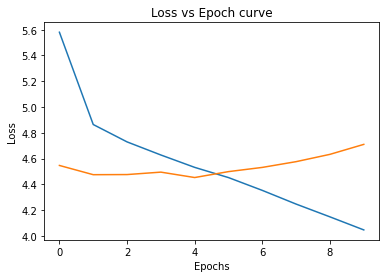

In [ ]:
train_test_metrics_graph(train_loss_all, val_loss_all)